In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelBinarizer
from imblearn.over_sampling import SMOTE

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from focal_loss import SparseCategoricalFocalLoss
import tensorflow as tf

from sklearn.metrics import classification_report
import matplotlib.pyplot as plt 
from sklearn.metrics import roc_curve, auc

tf.random.set_seed(42)
np.random.seed(42)

# Reading in pickle files

In [2]:
X_train = pd.read_pickle('X_train.pkl')
X_test = pd.read_pickle('X_test.pkl')
y_train = pd.read_pickle('y_train.pkl')
y_test = pd.read_pickle('y_test.pkl')

# Drop frame.time

In [3]:
X_train.drop(columns=['frame.time'], inplace=True)
X_test.drop(columns=['frame.time'], inplace=True)

# Separate Normal Traffic and Attack Traffic from data for Training AutoEncoder and FCN

In [4]:
# Filter only Normal traffic from X_train 
normal_indices = y_train[y_train['Attack_type'] == 12].index
X_train_normal = X_train.iloc[normal_indices]

# Create y_test_label which is binary, 0 for normal 1 for attack
y_test_label = np.where(y_test['Attack_type'] == 12, 0, 1)

# Filter only Attack Traffic from X_train
attack_indices_train = y_train[y_train['Attack_type'] != 12].index
X_train_attack = X_train.iloc[attack_indices_train]
y_train_attack = y_train.iloc[attack_indices_train]

# Create y_test_label which only has attack
attack_indices_test = y_test[y_test['Attack_type'] != 12].index
X_test_attack = X_test.iloc[attack_indices_test]
y_test_attack = y_test.iloc[attack_indices_test]

# 2 Part Model Without Frame Time

## AutoEncoder

In [5]:
# Model
input_dim = X_train_normal.shape[1]

ae_no_time = Sequential()
ae_no_time.add(Dense(units=input_dim, input_dim=input_dim, activation='leaky_relu'))
ae_no_time.add(Dropout(0.2))
ae_no_time.add(Dense(units=128, activation='leaky_relu'))
ae_no_time.add(Dropout(0.2))
ae_no_time.add(Dense(units=64, activation='leaky_relu'))
ae_no_time.add(Dense(units=32, activation='leaky_relu'))
ae_no_time.add(Dense(units=64, activation='leaky_relu'))
ae_no_time.add(Dropout(0.2))
ae_no_time.add(Dense(units=128, activation='leaky_relu'))
ae_no_time.add(Dropout(0.2))
ae_no_time.add(Dense(units=input_dim, activation='leaky_relu'))
 
ae_no_time.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss',  # Metric to monitor
                               patience=7,          # Number of epochs to wait after no improvement
                               restore_best_weights=True)  # Restores model to the best weights when stopped

reduce_lr = ReduceLROnPlateau(monitor='val_loss',    # Metric to monitor
                              factor=0.5,           # Factor by which to reduce the learning rate
                              patience=5,           # Number of epochs with no improvement before reducing LR
                              min_lr=1e-6)  

# Train using normal traffic data for both inputs and outputs
ae_no_time_hist = ae_no_time.fit(X_train_normal, X_train_normal,  
                epochs=100,                   
                batch_size=500,
                validation_split=0.2,
                callbacks = [early_stopping,reduce_lr])       



c:\Users\user\Desktop\DSA4266 Project\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
1371/1371 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.3192 - loss: 0.0160 - val_accuracy: 0.6135 - val_loss: 3.9350e-04 - learning_rate: 0.0010
Epoch 2/100
1371/1371 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.4421 - loss: 0.0020 - val_accuracy: 0.4681 - val_loss: 2.7543e-04 - learning_rate: 0.0010
Epoch 3/100
1371/1371 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.4621 - loss: 0.0015 - val_accuracy: 0.5243 - val_loss: 2.0825e-04 - learning_rate: 0.0010
Epoch 4/100
1371/1371 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.4728 - loss: 0.0012 - val_accuracy: 0.5641 - val_loss: 1.7751e-04 - learning_rate: 0.0010
Epoch 5/100
1371/1371 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.4754 - loss: 0.0010 - val_accuracy: 0.4667 - val_loss: 1.6585e-04 - learning_rate: 0.0010
Epoch 6/100
1371/1371 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.4804 - loss: 9.0622e-04 - val_accuracy: 0.5250 - val_loss: 1.6405e-04 - learning_rate: 0.0010
Epoch 7/100
1371/1371 ━━━━━━━━━━━━━━━━━━━

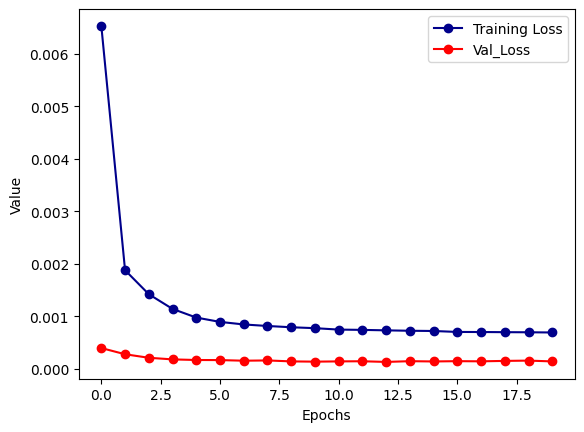

In [6]:
# Training and Validation Loss Plots
plt.plot(ae_no_time_hist.history['loss'], label='Training Loss', marker='o', color='darkblue')
plt.plot(ae_no_time_hist.history['val_loss'], label='Val_Loss', marker='o', color='red')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

19852/19852 ━━━━━━━━━━━━━━━━━━━━ 15s 770us/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    367217
           1       1.00      1.00      1.00    268028

    accuracy                           1.00    635245
   macro avg       1.00      1.00      1.00    635245
weighted avg       1.00      1.00      1.00    635245



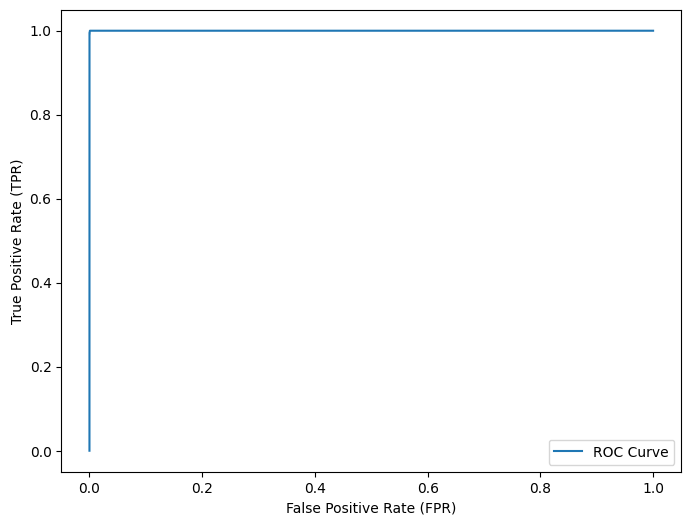

In [7]:
###################################################################################################
# Predictions
ae_no_time_pred = ae_no_time.predict(X_test)
# MSE between true X_test and pred_X_test
mse_no_time = np.mean(np.power(X_test - ae_no_time_pred, 2), axis=1)

###################################################################################################
# Plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test_label, mse_no_time)
youden_index = np.argmax(tpr - fpr)
optimal_threshold = thresholds[youden_index]

###################################################################################################
# Identify Anomaly based on MSE Threshold
threshold = optimal_threshold
anomaly_labels_no_time = np.where(mse_no_time > threshold, 1, 0)

###################################################################################################
#  Classification Report 
print(classification_report(y_test_label, anomaly_labels_no_time))

###################################################################################################
# ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend()
plt.show()

## Fully Connected Network  

In [8]:
# SMOTE on Attack Traffic
smote = SMOTE(random_state=42)
X_resampled_attack, y_resampled_attack = smote.fit_resample(X_train_attack, y_train_attack)

In [9]:
# Model
attack_FCN_no_time = Sequential()
attack_FCN_no_time.add(Dense(units=256, input_dim=X_resampled_attack.shape[1],activation='leaky_relu'))
attack_FCN_no_time.add(Dropout(0.2))
attack_FCN_no_time.add(Dense(units=128,activation='leaky_relu'))
attack_FCN_no_time.add(Dropout(0.2))
attack_FCN_no_time.add(Dense(units=64,activation='leaky_relu'))
attack_FCN_no_time.add(LayerNormalization())
attack_FCN_no_time.add(Dropout(0.2))
attack_FCN_no_time.add(Dense(units=12, activation='softmax'))

attack_FCN_no_time.compile(optimizer='adam', loss= 'sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss',  # Metric to monitor
                               patience=7,          # Number of epochs to wait after no improvement
                               restore_best_weights=True)  # Restores model to the best weights when stopped

reduce_lr = ReduceLROnPlateau(monitor='val_loss',    # Metric to monitor
                              factor=0.5,           # Factor by which to reduce the learning rate
                              patience=5,           # Number of epochs with no improvement before reducing LR
                              min_lr=1e-6)  

attack_FCN_no_time_hist = attack_FCN_no_time.fit(X_resampled_attack, y_resampled_attack, batch_size=500, epochs=200,callbacks=[early_stopping,reduce_lr],validation_split=0.2)


c:\Users\user\Desktop\DSA4266 Project\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
2001/2001 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.8067 - loss: 0.5474 - val_accuracy: 0.2679 - val_loss: 1.8054 - learning_rate: 0.0010
Epoch 2/200
2001/2001 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8657 - loss: 0.3433 - val_accuracy: 0.2837 - val_loss: 1.7571 - learning_rate: 0.0010
Epoch 3/200
2001/2001 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8695 - loss: 0.3332 - val_accuracy: 0.2766 - val_loss: 1.7638 - learning_rate: 0.0010
Epoch 4/200
2001/2001 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.8715 - loss: 0.3294 - val_accuracy: 0.2677 - val_loss: 1.7667 - learning_rate: 0.0010
Epoch 5/200
2001/2001 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8724 - loss: 0.3265 - val_accuracy: 0.2827 - val_loss: 1.7206 - learning_rate: 0.0010
Epoch 6/200
2001/2001 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8731 - loss: 0.3238 - val_accuracy: 0.2825 - val_loss: 1.7262 - learning_rate: 0.0010
Epoch 7/200
2001/2001 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0

8376/8376 ━━━━━━━━━━━━━━━━━━━━ 7s 782us/step
                       precision    recall  f1-score   support

             Backdoor       0.99      0.94      0.97      7459
            DDoS_HTTP       0.80      0.91      0.85     44658
            DDoS_ICMP       1.00      1.00      1.00     43715
             DDoS_TCP       1.00      1.00      1.00     42422
    OS_Fingerprinting       0.34      0.88      0.49       300
             Password       0.74      0.87      0.80     44242
        Port_Scanning       0.97      0.93      0.95      6769
           Ransomware       0.78      0.93      0.85      3278
        SQL_injection       0.85      0.63      0.72     15361
            Uploading       0.92      0.54      0.68     11290
Vulnerability_scanner       0.98      0.93      0.96     43759
                  XSS       0.85      0.21      0.34      4775

             accuracy                           0.89    268028
            macro avg       0.85      0.81      0.80    268028
        

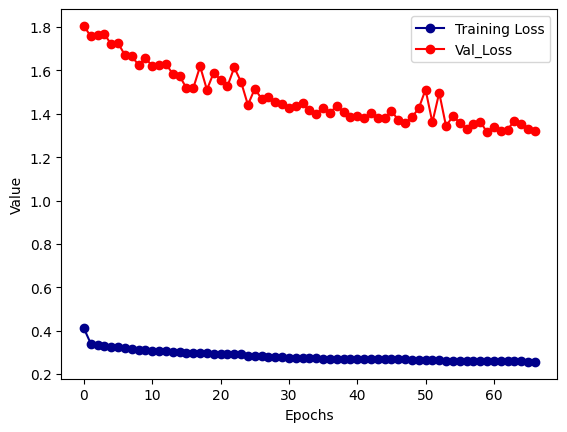

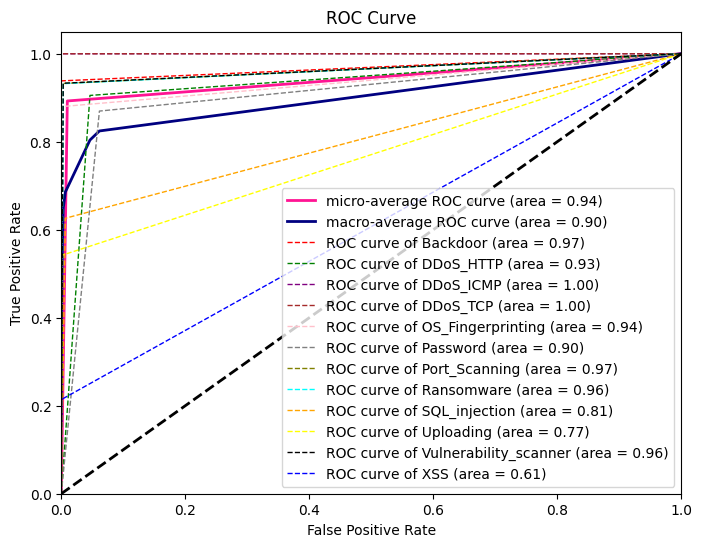

In [10]:
###################################################################################################
# Prediction
y_pred_prob_no_time = attack_FCN_no_time.predict(X_test_attack)
y_pred_no_time = np.argmax(y_pred_prob_no_time, axis=1)

###################################################################################################
# Classification Report
target_names = ['Backdoor',
                'DDoS_HTTP',
                'DDoS_ICMP',
                'DDoS_TCP',
                'OS_Fingerprinting',
                'Password',
                'Port_Scanning',
                'Ransomware',
                'SQL_injection',
                'Uploading',
                'Vulnerability_scanner',
                'XSS']
print(classification_report(y_test_attack, y_pred_no_time,target_names= target_names))

###################################################################################################
# Training and Validation Loss Plots
plt.plot(attack_FCN_no_time_hist.history['loss'], label='Training Loss', marker='o', color='darkblue')
plt.plot(attack_FCN_no_time_hist.history['val_loss'], label='Val_Loss', marker='o', color='red')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()


###################################################################################################
# ROC Curves for all Attack_type
def plot_roc_curve(y_true, y_pred, n_classes):
    # Binarize the output
    lb = LabelBinarizer()
    y_true = lb.fit_transform(y_true)
    y_pred = lb.transform(y_pred)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(8, 6))
    plt.plot(fpr["micro"], tpr["micro"],
             label=f'micro-average ROC curve (area = {roc_auc["micro"]:0.2f})',
             color='deeppink', linewidth=2)

    plt.plot(fpr["macro"], tpr["macro"],
             label=f'macro-average ROC curve (area = {roc_auc["macro"]:0.2f})',
             color='navy', linewidth=2)

    colors = ['red', 'green', 'purple', 'brown', 'pink', 'gray', 'olive',
              'cyan', 'orange', 'yellow', 'black', 'blue', 'magenta']

    ## plot micro and macro auc-roc curve
    type_mapping = {
    'Backdoor': 0,
    'DDoS_HTTP': 1,
    'DDoS_ICMP': 2,
    'DDoS_TCP': 3,
    'OS_Fingerprinting': 4,
    'Password': 5,
    'Port_Scanning': 6,
    'Ransomware': 7,
    'SQL_injection': 8,
    'Uploading': 9,
    'Vulnerability_scanner': 10,
    'XSS': 11} 
    reverse_type_mapping = {v: k for k, v in type_mapping.items()}
    for i, color in zip(range(n_classes), colors):
        # class_name = lb.classes_[i]
        class_name = reverse_type_mapping[lb.classes_[i]]
        plt.plot(fpr[i], tpr[i], color=color, lw=1,
             label=f'ROC curve of {class_name} (area = {roc_auc[i]:0.2f})',
             linestyle='--')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()
plot_roc_curve(y_test_attack, y_pred_no_time, n_classes=len(np.unique(y_test_attack)))

# Combining Both AE and FCN

19852/19852 ━━━━━━━━━━━━━━━━━━━━ 15s 732us/step
8382/8382 ━━━━━━━━━━━━━━━━━━━━ 7s 781us/step
                       precision    recall  f1-score   support

             Backdoor       0.99      0.94      0.96      7459
            DDoS_HTTP       0.80      0.91      0.85     44658
            DDoS_ICMP       1.00      1.00      1.00     43715
             DDoS_TCP       1.00      1.00      1.00     42422
    OS_Fingerprinting       0.33      0.88      0.48       300
             Password       0.74      0.87      0.80     44242
        Port_Scanning       0.96      0.93      0.95      6769
           Ransomware       0.77      0.93      0.84      3278
        SQL_injection       0.85      0.63      0.72     15361
            Uploading       0.92      0.54      0.68     11290
Vulnerability_scanner       0.98      0.93      0.96     43759
                  XSS       0.85      0.21      0.34      4775
               Normal       1.00      1.00      1.00    367217

             accuracy  

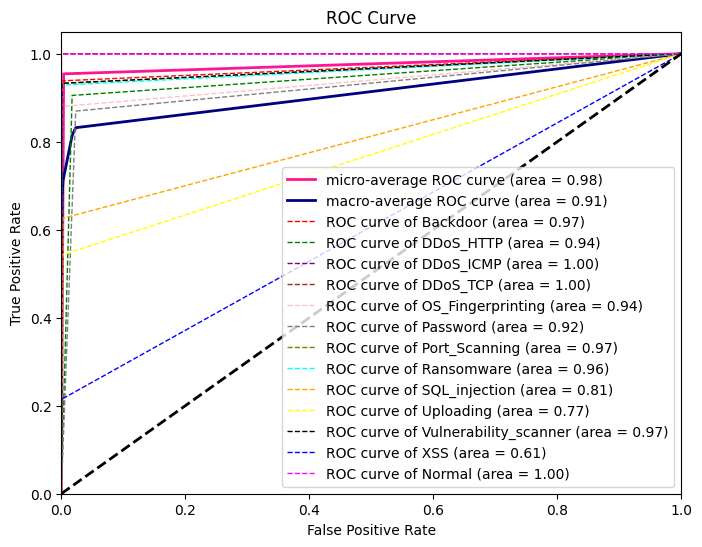

In [11]:
def combined_predict_no_time(X_test):
    # Step 1: Autoencoder Prediction for Anomaly Detection
    reconstruction = ae_no_time.predict(X_test)
    reconstruction_error = np.mean(np.square(X_test - reconstruction), axis=1)
    
    # Determine anomalies based on threshold chosen when evaluating AE
    threshold = optimal_threshold

    # based on threshold determine which are normal
    is_anomaly = reconstruction_error > threshold

    y_pred = np.full(len(X_test), 12)  # Initialize predictions as "Normal" (or 12)

    # Classify anomalies with the FCN model
    if np.any(is_anomaly):
        anomaly_data = X_test[is_anomaly]
        y_pred_anomaly = attack_FCN_no_time.predict(anomaly_data).argmax(axis=1)  # Get predicted attack class
        y_pred[is_anomaly] = y_pred_anomaly
    return y_pred

###################################################################################################
# Classification Report
final_y_pred_no_time = combined_predict_no_time(X_test)
target_names = ['Backdoor',
                'DDoS_HTTP',
                'DDoS_ICMP',
                'DDoS_TCP',
                'OS_Fingerprinting',
                'Password',
                'Port_Scanning',
                'Ransomware',
                'SQL_injection',
                'Uploading',
                'Vulnerability_scanner',
                'XSS',
                'Normal']
print(classification_report(y_test, final_y_pred_no_time,target_names=target_names)) 


###################################################################################################
# ROC Curves for all Attack_type
def plot_roc_curve(y_true, y_pred, n_classes):
    # Binarize the output
    lb = LabelBinarizer()
    y_true = lb.fit_transform(y_true)
    y_pred = lb.transform(y_pred)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(8, 6))
    plt.plot(fpr["micro"], tpr["micro"],
             label=f'micro-average ROC curve (area = {roc_auc["micro"]:0.2f})',
             color='deeppink', linewidth=2)

    plt.plot(fpr["macro"], tpr["macro"],
             label=f'macro-average ROC curve (area = {roc_auc["macro"]:0.2f})',
             color='navy', linewidth=2)

    colors = ['red', 'green', 'purple', 'brown', 'pink', 'gray', 'olive',
              'cyan', 'orange', 'yellow', 'black', 'blue', 'magenta']

    ## plot micro and macro auc-roc curve
    type_mapping = {
    'Backdoor': 0,
    'DDoS_HTTP': 1,
    'DDoS_ICMP': 2,
    'DDoS_TCP': 3,
    'OS_Fingerprinting': 4,
    'Password': 5,
    'Port_Scanning': 6,
    'Ransomware': 7,
    'SQL_injection': 8,
    'Uploading': 9,
    'Vulnerability_scanner': 10,
    'XSS': 11,
    'Normal':12} 
    reverse_type_mapping = {v: k for k, v in type_mapping.items()}
    for i, color in zip(range(n_classes), colors):
        # class_name = lb.classes_[i]
        class_name = reverse_type_mapping[lb.classes_[i]]
        plt.plot(fpr[i], tpr[i], color=color, lw=1,
             label=f'ROC curve of {class_name} (area = {roc_auc[i]:0.2f})',
             linestyle='--')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()
plot_roc_curve(y_test, final_y_pred_no_time, n_classes=len(np.unique(y_test)))